The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# Adagrad
:label:`sec_adagrad`

([本节](https://github.com/d2l-ai/d2l-zh/tree/release/chapter_optimization)是机器翻译，欢迎[贡献](https://zh.d2l.ai/chapter_appendix/how-to-contribute.html)改进)

让我们首先考虑一下不经常出现的功能的学习问题。

## 稀疏功能和学习率

想象一下我们正在训练语言模型。为了获得良好的准确性，我们通常希望在我们继续训练的同时降低学习率，通常是 $\mathcal{O}(t^{-\frac{1}{2}})$ 或更低的速度。现在考虑关于稀疏特征的模型训练，即只是不经常出现的特征。这对于自然语言来说很常见，例如，我们看到这个词 * 预先条件 * 比 * 学习 * 的可能性要小得多。但是，它在计算广告和个性化协作过滤等其他领域也很常见。毕竟，有许多事情只对少数人感兴趣。

只有在发生这些功能时，与不常见功能相关的参数才会收到有意义鉴于学习率下降，我们可能会最终处于这样一种情况：共同特征的参数相当迅速地收敛到最佳值，而对于不频繁的特征，我们仍然没有足够频繁地观察它们，然后才能确定其最佳值。换句话说，对于频繁的功能来说，学习速率下降太慢，要么对于不频繁的功能而言，学习率降低

解决这个问题的一个可能的黑客办法是计算我们看到特定功能的次数，并将其用作调整学习率的时钟。也就是说，我们可以使用 $\eta_i = \frac{\eta_0}{\sqrt{s(i, t) + c}}$，而不是选择 $\eta = \frac{\eta_0}{\sqrt{t + c}}$ 的形式的学习率。这里 $s(i, t)$ 计算了我们在 $t$ 之前观察到的功能 $i$ 的非零数。这实际上很容易在没有意义的开销的情况下实施。但是，只要我们没有太稀疏，而只是渐变通常非常小且很少大的数据，它就会失败。毕竟，目前尚不清楚在哪里划定符合观察特征资格的东西之间的界线。

Agrad by :cite:`Duchi.Hazan.Singer.2011` 通过将相当粗糙的计数器 $s(i, t)$ 替换为先前观察到的梯度的平方的合计来解决这个问题。特别是，它使用 $s(i, t+1) = s(i, t) + \left(\partial_i f(\mathbf{x})\right)^2$ 作为调整学习率的手段。这有两个好处：首先，我们不再需要仅仅决定梯度何时足够大。其次，它会随渐变的大小自动缩放。通常对应于大渐变的坐标会显著缩小，而其他梯度较小的坐标则会得到更温和的处理。实际上，这导致了计算广告和相关问题的非常有效的优化程序。但是，这隐藏了 Adagrad 固有的一些额外好处，这些好处在预调环境中最能理解。

## 预处理

凸优化问题有助于分析算法的特征。毕竟，对于大多数非凸问题来说，很难获得有意义的理论保证，但是 * 直觉 * 和 * 洞察 * 往往会延续。让我们来看看最小化 $f(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{c}^\top \mathbf{x} + b$ 的问题。

正如我们在 :numref:`sec_momentum` 中看到的那样，可以根据其特征组成 $\mathbf{Q} = \mathbf{U}^\top \boldsymbol{\Lambda} \mathbf{U}$ 重写这个问题，以便得出一个简化得多的问题，其中每个坐标都可以单独解决：

$$f(\mathbf{x}) = \bar{f}(\bar{\mathbf{x}}) = \frac{1}{2} \bar{\mathbf{x}}^\top \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}}^\top \bar{\mathbf{x}} + b.$$

在这里我们使用了 $\mathbf{x} = \mathbf{U} \mathbf{x}$，因此使用了 $\mathbf{c} = \mathbf{U} \mathbf{c}$。修改后的问题的最小值为 $\bar{\mathbf{x}} = -\boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}}$ 和最小值为 $-\frac{1}{2} \bar{\mathbf{c}}^\top \boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}} + b$。这更容易计算，因为 $\boldsymbol{\Lambda}$ 是一个包含 $\mathbf{Q}$ 特征值的对角矩阵。

如果我们稍微扰动 $\mathbf{c}$，我们希望只能在 $f$ 的最小值中找到微小的变化。不幸的是，情况并非如此。虽然 $\mathbf{c}$ 的轻微变化导致 $\bar{\mathbf{c}}$ 同样微小的变化，但最小值 $f$（分别为 $\bar{f}$）的最小值并非如此。每当特征值 $\boldsymbol{\Lambda}_i$ 很大时，我们只会看到 $\bar{x}_i$ 和最低 $\bar{f}$ 的小变化。相反，对于 $\boldsymbol{\Lambda}_i$ 小的 $\boldsymbol{\Lambda}_i$ 来说，$\bar{x}_i$ 的变化可能是戏剧性的。最大和最小的特征值之间的比率称为优化问题的条件编号。

$$\kappa = \frac{\boldsymbol{\Lambda}_1}{\boldsymbol{\Lambda}_d}.$$

如果条件编号 $\kappa$ 很大，则很难准确解决优化问题。我们需要确保我们谨慎地获得大量的动态价值范围。我们的分析导致了一个显而易见但有点天真的问题：我们难道不能简单地通过扭曲空间来 “修复” 问题，使所有特征值都是 $1$。理论上这很容易：我们只需要 $\mathbf{Q}$ 的特征值和特征向量即可将问题从 $\mathbf{x}$ 重新调整到 $\mathbf{z} := \boldsymbol{\Lambda}^{\frac{1}{2}} \mathbf{U} \mathbf{x}$ 中的一个。在新的坐标系中，$\mathbf{x}^\top \mathbf{Q} \mathbf{x}$ 可以简化为 $\|\mathbf{z}\|^2$。唉，这是一个相当不切实际的建议。一般而言，计算特征值和特征向量比解决实际问题要贵得多 *。

虽然计算特征值准确可能会很昂贵，但猜测它们和计算它们甚至有点近似可能已经比根本不做任何事情要好得多。特别是，我们可以使用 $\mathbf{Q}$ 的对角线条目并相应地重新缩放它。这比计算特征值便宜 * 很多。

$$\tilde{\mathbf{Q}} = \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q}) \mathbf{Q} \mathrm{diag}^{-\frac{1}{2}}(\mathbf{Q}).$$

在这种情况下，我们有 $\tilde{\mathbf{Q}}_{ij} = \mathbf{Q}_{ij} / \sqrt{\mathbf{Q}_{ii} \mathbf{Q}_{jj}}$，特别是 $\tilde{\mathbf{Q}}_{ii} = 1$，对于所有 $i$。在大多数情况下，这大大简化了状况编号。例如，我们之前讨论的案例，这将完全消除眼前的问题，因为问题是轴对齐的。

不幸的是，我们面临另一个问题：在深度学习中，我们通常甚至无法访问目标函数的第二个衍生物：对于 $\mathbf{x} \in \mathbb{R}^d$，即使在迷你手表上，第二个衍生物也可能需要 $\mathcal{O}(d^2)$ 空间和计算，因此几乎不可行。Agrad 的巧妙想法是使用代理来表示黑森州那个难以捉摸的对角线，该对角线既比较便宜又比较便宜且有效 —— 梯度本身的大小。

为了了解这为什么起作用，让我们来看 $\bar{f}(\bar{\mathbf{x}})$。我们有

$$\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}}) = \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}} = \boldsymbol{\Lambda} \left(\bar{\mathbf{x}} - \bar{\mathbf{x}}_0\right),$$

其中 $\bar{\mathbf{x}}_0$ 是 $\bar{f}$ 的最小值。因此，梯度的大小取决于 $\boldsymbol{\Lambda}$ 和与最佳性的距离。如果 $\bar{\mathbf{x}} - \bar{\mathbf{x}}_0$ 没有改变，这将是所需的。毕竟，在这种情况下，梯度 $\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}})$ 的大小就足够了。由于 AdAgrAD 是一种随机梯度下降算法，因此即使在最优性下，我们也会看到具有非零方差的渐变。因此，我们可以安全地使用渐变的方差作为黑森州比例的廉价代理。彻底的分析超出了本节的范围（将有几页）。有关详细信息，我们请读者参考 :cite:`Duchi.Hazan.Singer.2011`。

## 该算法

让我们从上面正式化讨论。我们使用变量 $\mathbf{s}_t$ 来累计过去的梯度方差，如下所示。

$$\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}$$

在这里，操作是明智地应用坐标的。也就是说，$\mathbf{v}^2$ 有条目 $v_i^2$。同样，$\frac{1}{\sqrt{v}}$ 有条目 $\frac{1}{\sqrt{v_i}}$，$\mathbf{u} \cdot \mathbf{v}$ 有条目 $u_i v_i$。与之前 $\eta$ 一样是学习率，$\epsilon$ 是一个加法常数，可确保我们不会除以 $0$。最后，我们初始化 $\mathbf{s}_0 = \mathbf{0}$。

就像动量一样，我们需要跟踪辅助变量，在这种情况下，为了允许每个坐标单独的学习率。这并没有显著增加 Agrad 的成本与新加坡元相比，因为主要成本通常是计算 $l(y_t, f(\mathbf{x}_t, \mathbf{w}))$ 及其衍生品。

请注意，在 $\mathbf{s}_t$ 中累积平方梯度意味着 $\mathbf{s}_t$ 基本上以线性速率增长（因为渐变最初减少，比实际上线性慢一些）。这导致了 $\mathcal{O}(t^{-\frac{1}{2}})$ 的学习率，尽管是在每个坐标的基础上进行了调整。对于凸出的问题，这完全足够了。但是，在深度学习中，我们可能希望更慢地降低学习率。这导致了许多 Agrad 变体，我们将在后续章节中讨论这些变体。现在让我们看看它在二次凸问题中的表现如何。我们使用和以前相同的问题：

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

我们将使用之前相同的学习率来实施 Agrad，即 $\eta = 0.4$。正如我们所看到的，独立变量的迭代轨迹更平滑。但是，由于 $\boldsymbol{s}_t$ 的累积效应，学习率持续下降，因此独立变量在迭代的后期阶段移动不会那么多。


In [1]:
%matplotlib inline
import math
import tensorflow as tf
from d2l import tensorflow as d2l


epoch 20, x1: -2.382563, x2: -0.158591


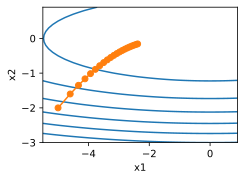

In [2]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

随着我们将学习率提高到 $2$，我们看到了更好的行为。这已经表明，即使在无噪音的情况下，学习率的降低可能相当激烈，我们需要确保参数适当地收敛。


epoch 20, x1: -0.002295, x2: -0.000000


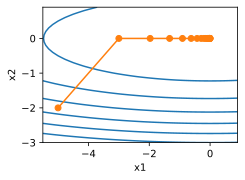

In [3]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

## 从头开始实施

就像动量方法一样，Agrad 需要保持与参数形状相同的状态变量。


In [4]:
def init_adagrad_states(feature_dim):
    s_w = tf.Variable(tf.zeros((feature_dim, 1)))
    s_b = tf.Variable(tf.zeros(1))
    return (s_w, s_b)

def adagrad(params, grads, states, hyperparams):
    eps = 1e-6
    for p, s, g in zip(params, states, grads):
        s[:].assign(s + tf.math.square(g))
        p[:].assign(p - hyperparams['lr'] * g / tf.math.sqrt(s + eps))

与 :numref:`sec_minibatch_sgd` 的实验相比，我们使用更高的学习率来训练模型。


loss: 0.242, 0.074 sec/epoch


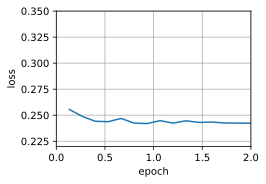

In [5]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

## 简洁的实施

使用算法 `adagrad` 的 `Trainer` 实例，我们可以在 Gluon 中调用 Agrad 算法。


loss: 0.243, 0.078 sec/epoch


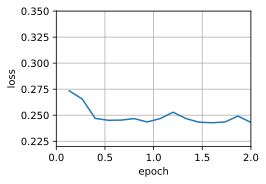

In [6]:
trainer = tf.keras.optimizers.Adagrad
d2l.train_concise_ch11(trainer, {'learning_rate' : 0.1}, data_iter)

## 摘要

* Agrad 会在每个坐标的基础上动态降低学习率。
* 它利用梯度的大小作为调整取得进展的速度的手段-用较小的学习率来补偿带有较大梯度的坐标。
* 由于内存和计算限制，在深度学习问题中，计算准确的第二导数通常是不可行的。渐变可能是一个有用的代理。
* 如果优化问题的结构相当不均匀，那么 Agrad 可以帮助缓解扭曲。
* Agrad 对于稀疏功能特别有效，因为对于不常出现的术语，学习率需要更慢地降低。
* 在深度学习问题上，Agrad 有时在降低学习率方面可能过于激进。我们将在 :numref:`sec_adam` 的背景下讨论缓解这种情况的策略。

## 练习

1. 证明对于正交矩阵 $\mathbf{U}$ 和向量 $\mathbf{c}$，以下是：$\|\mathbf{c} - \mathbf{\delta}\|_2 = \|\mathbf{U} \mathbf{c} - \mathbf{U} \mathbf{\delta}\|_2$。为什么这意味着在变量的正交变化之后，扰动的程度不会改变？
1. 尝试使用 Agrad 为 $f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2$，而且对于目标功能旋转 45 度，即 $f(\mathbf{x}) = 0.1 (x_1 + x_2)^2 + 2 (x_1 - x_2)^2$。它的行为会不同吗？
1. 证明 [格尔施戈林的圆定理]（https://en.wikipedia.org/wiki/Gershgorin_circle_theorem），其中指出，矩阵 $\mathbf{M}$ 的特征值 $\lambda_i$ 在至少一个 $j$ 的选择中满足 $|\lambda_i - \mathbf{M}_{jj}| \leq \sum_{k \neq j} |\mathbf{M}_{jk}|$ 的要求。
1. 关于对角线预处理矩阵 $\mathrm{diag}^{-\frac{1}{2}}(\mathbf{M}) \mathbf{M} \mathrm{diag}^{-\frac{1}{2}}(\mathbf{M})$ 的特征值，Gerschgorin 的定理告诉我们什么？
1. 尝试使用 Agrad 获得适当的深度网络，例如，当应用于时尚 MNIST 时，:numref:`sec_lenet`。
1. 你需要如何修改 Agrad 才能在学习率方面实现不那么激进的衰减？


[Discussions](https://discuss.d2l.ai/t/1073)
